In [1]:
import os
import sys
import warnings
import pandas as pd
from tqdm.notebook import tqdm

base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
print(f"base_path: {base_path}")
sys.path.append(base_path)

base_path: /home/toc3/press


In [2]:
from socceraction.data.statsbomb import StatsBombLoader
from statsbombpy import sb
from express.databases import SQLiteDatabase
from express.visualization import plot_action
from express.utils import add_names

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
SBL = StatsBombLoader(root=os.path.join(base_path, "open-data/data"), getter="local")
competition = sb.competitions()

# HTTPError: 404 Client Error: Not Found for ur
Error_competition = [(11, 90), (7, 235), (7, 108), (44, 107)] # La-Liga 20/21, Ligue1 21/22, Ligue1 22/23 
competition = competition[~competition[["competition_id", "season_id"]].apply(tuple, axis=1).isin(Error_competition)] # HTTPError: 404 Client Error: Not Found for ur
competition = competition[(competition["match_available_360"].notna()) & (competition["competition_gender"] == "male")]
competition

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,281,Germany,1. Bundesliga,male,False,False,2023/2024,2024-07-15T14:15:54.671676,2024-07-15T14:17:00.877356,2024-07-15T14:17:00.877356,2024-07-15T14:15:54.671676
29,43,106,International,FIFA World Cup,male,False,True,2022,2024-05-15T10:23:32.854925,2024-06-11T11:30:50.462448,2024-06-11T11:30:50.462448,2024-05-15T10:23:32.854925
68,55,282,Europe,UEFA Euro,male,False,True,2024,2024-07-15T15:48:50.315500,2024-07-15T15:52:24.778809,2024-07-15T15:52:24.778809,2024-07-15T15:48:50.315500
69,55,43,Europe,UEFA Euro,male,False,True,2020,2024-04-16T12:44:40.558402,2024-04-16T12:47:18.505110,2024-04-16T12:47:18.505110,2024-04-16T12:44:40.558402


In [ ]:
games = pd.concat([
    SBL.games(row.competition_id, row.season_id)
    for row in tqdm(competition.itertuples())
]).reset_index(drop=True)

train_games = games[
    ((games['competition_id'] == 9) & (games['season_id'] == 281) & (games['game_day'] <= 17)) | # Bundesliga(1~17 Round)
    ((games['competition_id'] == 43) & (games['season_id'] == 106) & (games['game_day'] <= 2)) | # World Cup(1~2 Round)
    ((games['competition_id'] == 55) & (games['season_id'].isin([282, 43])))                     # UEFA Euro 2020, 2024
]

test_games = games[
    ((games['competition_id'] == 9) & (games['season_id'] == 281) & (games['game_day'] > 17)) | # Bundesliga(18~34 Round)
    ((games['competition_id'] == 43) & (games['season_id'] == 106) & (games['game_day'] > 2))   # World Cup(3~7 Round)
]

print(train_games.shape, test_games.shape)

0it [00:00, ?it/s]

(151, 12) (49, 12)


In [34]:
TRAIN_DB_PATH = os.path.join(base_path, "stores/train_database.sqlite")
TEST_DB_PATH = os.path.join(base_path, "stores/test_database.sqlite")

train_db = SQLiteDatabase(TRAIN_DB_PATH)
test_db = SQLiteDatabase(TEST_DB_PATH)

print("train_db:", train_db)
print("test_db:", test_db)

train_db: <express.databases.sqlite.SQLiteDatabase object at 0x7f2b4c258520>
test_db: <express.databases.sqlite.SQLiteDatabase object at 0x7f2b4c2580d0>


In [35]:
for _, game in tqdm(train_games.iterrows(), desc="train_game loading"):
    dataset = {"getter": "local", 
                "competition_id": game["competition_id"], 
                "season_id": game["season_id"], 
                "game_id": game["game_id"],
                "root": os.path.join(base_path, "open-data/data")}
    
    train_db.import_data(**dataset)

for _, game in tqdm(test_games.iterrows(), desc="test_game loading"):
    dataset = {"getter": "local", 
                "competition_id": game["competition_id"], 
                "season_id": game["season_id"], 
                "game_id": game["game_id"],
                "root": os.path.join(base_path, "open-data/data")}
    
    test_db.import_data(**dataset)

train_game loading: 0it [00:00, ?it/s]

test_game loading: 0it [00:00, ?it/s]

In [36]:
game_id = 3788741

df_actions = add_names(train_db.actions(game_id)).reset_index()
df_actions.head()

,game_id,action_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,...,play_pattern_name,under_pressure,duration,extra,visible_area_360,in_visible_area_360,freeze_frame_360,type_name,result_name,bodypart_name
0,3788741,0,5c888f58-fe77-459b-ab3b-a2fa5fb8ab16,1,0.878,909,11086,52.0625,34.425,28.0000,...,From Kick Off,0,1.910504,"{'pass': {'recipient': {'id': 8963, 'name': 'C...","[[0.0, 44.39976078697438], [16.82907029647681,...",0,"[{'teammate': False, 'actor': False, 'keeper':...",pass,success,foot_right
1,3788741,1,bea4235d-7e40-461c-bb82-6d473f5bb324,1,2.789,909,8963,28.0000,43.945,31.2375,...,From Kick Off,0,1.499077,"{'carry': {'end_location': [36.2, 30.4]}}","[[30.27094296623723, 2.3520882891309185], [5.7...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",dribble,success,foot
2,3788741,2,84b9b798-0fbe-45bc-a4bf-3621959f29ce,1,4.288,909,8963,31.2375,42.585,61.4250,...,From Kick Off,0,2.476772,"{'pass': {'recipient': {'id': 8541, 'name': 'K...","[[31.00063614049526, 1.2150785249513518], [6.7...",0,"[{'teammate': True, 'actor': False, 'keeper': ...",pass,success,foot_left
3,3788741,3,6e2955cf-ad4f-4096-a4dd-053173a3802b,1,6.751,914,8286,63.2625,6.715,63.2625,...,From Kick Off,0,0.080000,{},"[[87.6897292922602, 68.0], [68.82521396005053,...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pressing,fail,foot
4,3788741,4,1615d483-101d-45c1-b554-04cf69897232,1,6.764,909,8541,61.4250,3.995,61.1625,...,From Kick Off,1,0.101747,"{'carry': {'end_location': [70.4, 75.5]}}","[[69.32405800689574, 0.0], [40.54450680816471,...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",dribble,success,foot


909 914
Skip action due to missing freeze frame: 39


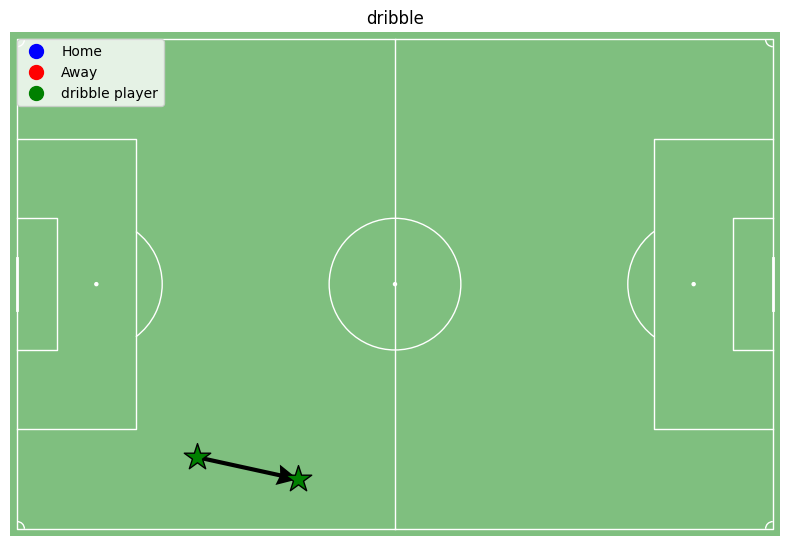

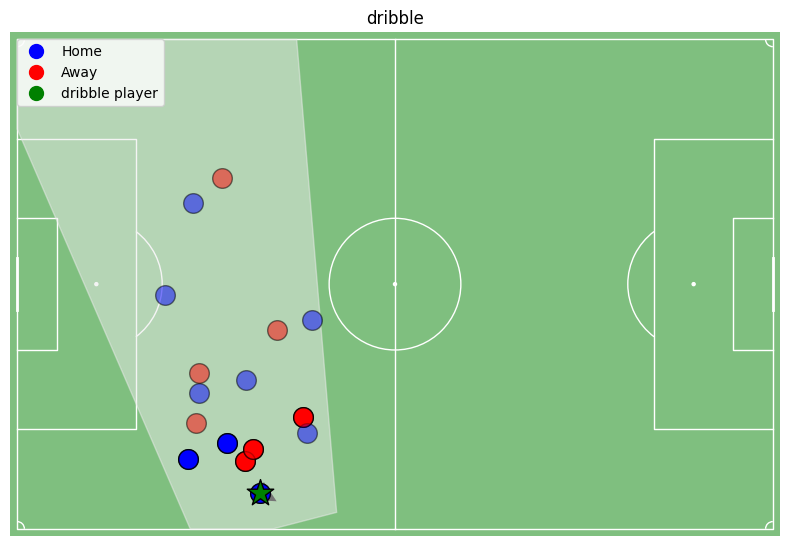

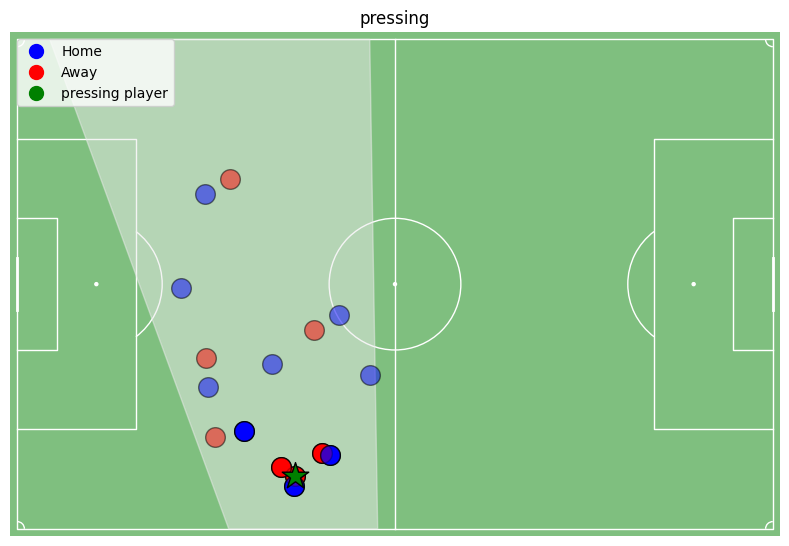

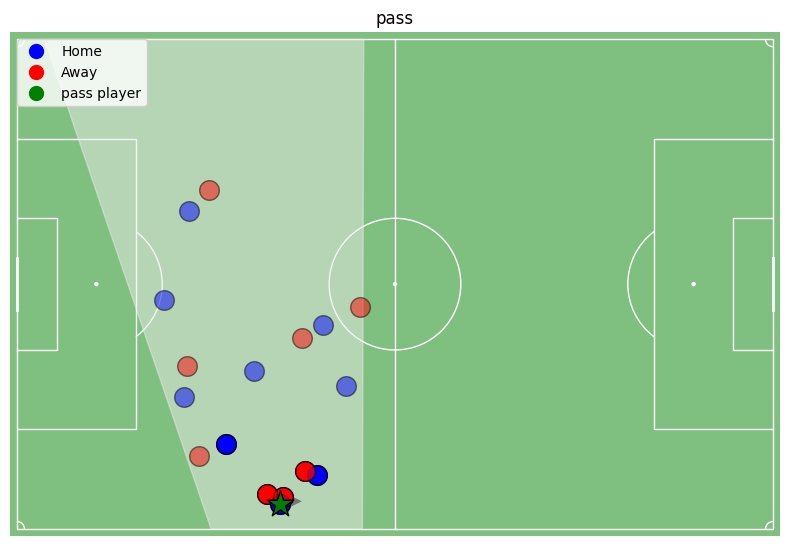

In [38]:
pressure_idx = df_actions[df_actions["type_name"] == "pressing"].index[5]
home_team_id, away_team_id = train_db.get_home_away_team_id(game_id = 3788741)

print(home_team_id, away_team_id)

for idx in range(pressure_idx-2, pressure_idx+2):
    if df_actions.loc[idx]["freeze_frame_360"] is None:
        print("Skip action due to missing freeze frame:",idx)
        plot_action(df_actions.loc[idx], home_team_id=home_team_id, show_visible_area=False)
    else:
        # plot_action: 데이터의 위치 정보는 홈팀은 left->right, 원정팀은 left<-right인 상태이다.
        plot_action(df_actions.loc[idx], home_team_id=home_team_id)